In [1]:
import librosa
from librosa import display

In [6]:
import os
import pandas as pd
import numpy as np
import glob 

In [7]:
import time

path = '/home/systemcommand/bangkit/puput/app/data/features/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: -24784.52386522293 seconds ---


In [8]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [9]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((5252, 40), (5252,))

In [10]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = "/home/systemcommand/bangkit/puput/app/data/features/joblib/"

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [52]:
# Loading saved models

X = joblib.load('/home/systemcommand/bangkit/puput/app/X.joblib')
y = joblib.load('/home/systemcommand/bangkit/puput/app/y.joblib')

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [54]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [55]:
x_traincnn.shape, x_testcnn.shape

((3518, 40, 1), (1734, 40, 1))

In [56]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_9 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_10 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 128)           

In [58]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [59]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
220/220 [==============================] - 4s 10ms/step - loss: 6.7653 - accuracy: 0.1499 - val_loss: 1.7770 - val_accuracy: 0.3887
Epoch 2/1000
220/220 [==============================] - 2s 7ms/step - loss: 4.3075 - accuracy: 0.2601 - val_loss: 1.5916 - val_accuracy: 0.4239
Epoch 3/1000
220/220 [==============================] - 2s 7ms/step - loss: 3.1254 - accuracy: 0.3389 - val_loss: 1.4984 - val_accuracy: 0.4919
Epoch 4/1000
220/220 [==============================] - 2s 7ms/step - loss: 2.4141 - accuracy: 0.3952 - val_loss: 1.3295 - val_accuracy: 0.5531
Epoch 5/1000
220/220 [==============================] - 2s 7ms/step - loss: 1.9776 - accuracy: 0.4147 - val_loss: 1.2660 - val_accuracy: 0.5358
Epoch 6/1000
220/220 [==============================] - 2s 7ms/step - loss: 1.6249 - accuracy: 0.4997 - val_loss: 1.3102 - val_accuracy: 0.5531
Epoch 7/1000
220/220 [==============================] - 2s 7ms/step - loss: 1.5209 - accuracy: 0.4951 - val_loss: 1.1880 - val_accuracy

220/220 [==============================] - 2s 7ms/step - loss: 0.6644 - accuracy: 0.7555 - val_loss: 0.6860 - val_accuracy: 0.7434
Epoch 58/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.6672 - accuracy: 0.7543 - val_loss: 0.6591 - val_accuracy: 0.7607
Epoch 59/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.6525 - accuracy: 0.7596 - val_loss: 0.6685 - val_accuracy: 0.7566
Epoch 60/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.6904 - accuracy: 0.7491 - val_loss: 0.6494 - val_accuracy: 0.7641
Epoch 61/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.6579 - accuracy: 0.7648 - val_loss: 0.6559 - val_accuracy: 0.7561
Epoch 62/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.6480 - accuracy: 0.7612 - val_loss: 0.6659 - val_accuracy: 0.7520
Epoch 63/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.6350 - accuracy: 0.7619 - val_loss: 0.6382 - val_accuracy: 0.7653

220/220 [==============================] - 2s 7ms/step - loss: 0.5215 - accuracy: 0.8029 - val_loss: 0.5708 - val_accuracy: 0.7872
Epoch 114/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.5012 - accuracy: 0.8206 - val_loss: 0.5653 - val_accuracy: 0.7912
Epoch 115/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.5514 - accuracy: 0.7992 - val_loss: 0.5672 - val_accuracy: 0.7895
Epoch 116/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.5083 - accuracy: 0.8150 - val_loss: 0.5676 - val_accuracy: 0.7982
Epoch 117/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.5101 - accuracy: 0.8197 - val_loss: 0.5574 - val_accuracy: 0.8051
Epoch 118/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.5172 - accuracy: 0.8123 - val_loss: 0.5591 - val_accuracy: 0.7953
Epoch 119/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.5143 - accuracy: 0.8122 - val_loss: 0.5558 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.4430 - accuracy: 0.8441 - val_loss: 0.5243 - val_accuracy: 0.8085
Epoch 170/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.4010 - accuracy: 0.8539 - val_loss: 0.5280 - val_accuracy: 0.8103
Epoch 171/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.4366 - accuracy: 0.8428 - val_loss: 0.5326 - val_accuracy: 0.8178
Epoch 172/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.4428 - accuracy: 0.8460 - val_loss: 0.5628 - val_accuracy: 0.7947
Epoch 173/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.4081 - accuracy: 0.8558 - val_loss: 0.5181 - val_accuracy: 0.8131
Epoch 174/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3898 - accuracy: 0.8617 - val_loss: 0.5240 - val_accuracy: 0.8120
Epoch 175/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.4048 - accuracy: 0.8594 - val_loss: 0.5169 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.3792 - accuracy: 0.8616 - val_loss: 0.4883 - val_accuracy: 0.8264
Epoch 226/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3723 - accuracy: 0.8601 - val_loss: 0.5044 - val_accuracy: 0.8195
Epoch 227/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3755 - accuracy: 0.8623 - val_loss: 0.4810 - val_accuracy: 0.8224
Epoch 228/1000
220/220 [==============================] - 2s 8ms/step - loss: 0.3649 - accuracy: 0.8757 - val_loss: 0.4865 - val_accuracy: 0.8206
Epoch 229/1000
220/220 [==============================] - 2s 8ms/step - loss: 0.3982 - accuracy: 0.8613 - val_loss: 0.4910 - val_accuracy: 0.8201
Epoch 230/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3566 - accuracy: 0.8769 - val_loss: 0.4872 - val_accuracy: 0.8241
Epoch 231/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3619 - accuracy: 0.8722 - val_loss: 0.4952 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.3047 - accuracy: 0.8885 - val_loss: 0.4681 - val_accuracy: 0.8287
Epoch 282/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3180 - accuracy: 0.8884 - val_loss: 0.4792 - val_accuracy: 0.8299
Epoch 283/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3328 - accuracy: 0.8789 - val_loss: 0.5022 - val_accuracy: 0.8235
Epoch 284/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3026 - accuracy: 0.8918 - val_loss: 0.4892 - val_accuracy: 0.8391
Epoch 285/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3056 - accuracy: 0.8916 - val_loss: 0.4850 - val_accuracy: 0.8287
Epoch 286/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3274 - accuracy: 0.8805 - val_loss: 0.4759 - val_accuracy: 0.8345
Epoch 287/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3052 - accuracy: 0.8834 - val_loss: 0.4727 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.2891 - accuracy: 0.8974 - val_loss: 0.4596 - val_accuracy: 0.8414
Epoch 338/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.3084 - accuracy: 0.8993 - val_loss: 0.4602 - val_accuracy: 0.8431
Epoch 339/1000
220/220 [==============================] - 1s 7ms/step - loss: 0.2881 - accuracy: 0.8925 - val_loss: 0.4569 - val_accuracy: 0.8351
Epoch 340/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2607 - accuracy: 0.9119 - val_loss: 0.4583 - val_accuracy: 0.8304
Epoch 341/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2906 - accuracy: 0.8983 - val_loss: 0.4694 - val_accuracy: 0.8391
Epoch 342/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2786 - accuracy: 0.8981 - val_loss: 0.4702 - val_accuracy: 0.8368
Epoch 343/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2721 - accuracy: 0.9091 - val_loss: 0.4540 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.2339 - accuracy: 0.9188 - val_loss: 0.4643 - val_accuracy: 0.8345
Epoch 394/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2605 - accuracy: 0.9057 - val_loss: 0.4531 - val_accuracy: 0.8368
Epoch 395/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2429 - accuracy: 0.9106 - val_loss: 0.4474 - val_accuracy: 0.8414
Epoch 396/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2663 - accuracy: 0.9003 - val_loss: 0.4738 - val_accuracy: 0.8374
Epoch 397/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2326 - accuracy: 0.9154 - val_loss: 0.4545 - val_accuracy: 0.8374
Epoch 398/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2336 - accuracy: 0.9143 - val_loss: 0.4604 - val_accuracy: 0.8385
Epoch 399/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2250 - accuracy: 0.9188 - val_loss: 0.4641 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.2296 - accuracy: 0.9202 - val_loss: 0.4534 - val_accuracy: 0.8426
Epoch 450/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2131 - accuracy: 0.9262 - val_loss: 0.4639 - val_accuracy: 0.8379
Epoch 451/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2230 - accuracy: 0.9210 - val_loss: 0.4713 - val_accuracy: 0.8420
Epoch 452/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2083 - accuracy: 0.9359 - val_loss: 0.4497 - val_accuracy: 0.8529
Epoch 453/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2069 - accuracy: 0.9268 - val_loss: 0.4517 - val_accuracy: 0.8420
Epoch 454/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2099 - accuracy: 0.9282 - val_loss: 0.4648 - val_accuracy: 0.8437
Epoch 455/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2109 - accuracy: 0.9202 - val_loss: 0.4722 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.1840 - accuracy: 0.9350 - val_loss: 0.4488 - val_accuracy: 0.8495
Epoch 506/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1977 - accuracy: 0.9324 - val_loss: 0.4598 - val_accuracy: 0.8449
Epoch 507/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1932 - accuracy: 0.9317 - val_loss: 0.5031 - val_accuracy: 0.8345
Epoch 508/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1917 - accuracy: 0.9351 - val_loss: 0.4701 - val_accuracy: 0.8385
Epoch 509/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1827 - accuracy: 0.9383 - val_loss: 0.4627 - val_accuracy: 0.8379
Epoch 510/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.2127 - accuracy: 0.9276 - val_loss: 0.4410 - val_accuracy: 0.8431
Epoch 511/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1945 - accuracy: 0.9274 - val_loss: 0.4689 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.1617 - accuracy: 0.9424 - val_loss: 0.4736 - val_accuracy: 0.8460
Epoch 562/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1645 - accuracy: 0.9370 - val_loss: 0.4684 - val_accuracy: 0.8501
Epoch 563/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1720 - accuracy: 0.9410 - val_loss: 0.4531 - val_accuracy: 0.8466
Epoch 564/1000
220/220 [==============================] - 1s 7ms/step - loss: 0.1644 - accuracy: 0.9459 - val_loss: 0.4653 - val_accuracy: 0.8489
Epoch 565/1000
220/220 [==============================] - 1s 7ms/step - loss: 0.1804 - accuracy: 0.9342 - val_loss: 0.4781 - val_accuracy: 0.8403
Epoch 566/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1560 - accuracy: 0.9465 - val_loss: 0.4502 - val_accuracy: 0.8472
Epoch 567/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1787 - accuracy: 0.9396 - val_loss: 0.4644 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.1522 - accuracy: 0.9479 - val_loss: 0.4779 - val_accuracy: 0.8472
Epoch 618/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1698 - accuracy: 0.9428 - val_loss: 0.4701 - val_accuracy: 0.8524
Epoch 619/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1402 - accuracy: 0.9495 - val_loss: 0.4609 - val_accuracy: 0.8506
Epoch 620/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1472 - accuracy: 0.9512 - val_loss: 0.4580 - val_accuracy: 0.8552
Epoch 621/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1608 - accuracy: 0.9518 - val_loss: 0.4760 - val_accuracy: 0.8460
Epoch 622/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1550 - accuracy: 0.9459 - val_loss: 0.4527 - val_accuracy: 0.8512
Epoch 623/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1489 - accuracy: 0.9506 - val_loss: 0.4675 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.1377 - accuracy: 0.9462 - val_loss: 0.4954 - val_accuracy: 0.8483
Epoch 674/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1402 - accuracy: 0.9523 - val_loss: 0.4798 - val_accuracy: 0.8478
Epoch 675/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1355 - accuracy: 0.9567 - val_loss: 0.4713 - val_accuracy: 0.8501
Epoch 676/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1436 - accuracy: 0.9513 - val_loss: 0.4875 - val_accuracy: 0.8478
Epoch 677/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1444 - accuracy: 0.9556 - val_loss: 0.5002 - val_accuracy: 0.8535
Epoch 678/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1435 - accuracy: 0.9530 - val_loss: 0.4787 - val_accuracy: 0.8524
Epoch 679/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1449 - accuracy: 0.9486 - val_loss: 0.4637 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.1114 - accuracy: 0.9669 - val_loss: 0.4727 - val_accuracy: 0.8518
Epoch 730/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1315 - accuracy: 0.9569 - val_loss: 0.4757 - val_accuracy: 0.8558
Epoch 731/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1243 - accuracy: 0.9642 - val_loss: 0.5062 - val_accuracy: 0.8518
Epoch 732/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1296 - accuracy: 0.9579 - val_loss: 0.5061 - val_accuracy: 0.8518
Epoch 733/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1329 - accuracy: 0.9529 - val_loss: 0.4708 - val_accuracy: 0.8547
Epoch 734/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1333 - accuracy: 0.9511 - val_loss: 0.5453 - val_accuracy: 0.8460
Epoch 735/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1236 - accuracy: 0.9533 - val_loss: 0.4901 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.0984 - accuracy: 0.9678 - val_loss: 0.5246 - val_accuracy: 0.8541
Epoch 786/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1207 - accuracy: 0.9555 - val_loss: 0.4894 - val_accuracy: 0.8466
Epoch 787/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1145 - accuracy: 0.9641 - val_loss: 0.4991 - val_accuracy: 0.8529
Epoch 788/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1020 - accuracy: 0.9598 - val_loss: 0.4952 - val_accuracy: 0.8547
Epoch 789/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1264 - accuracy: 0.9595 - val_loss: 0.4870 - val_accuracy: 0.8599
Epoch 790/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1235 - accuracy: 0.9632 - val_loss: 0.5004 - val_accuracy: 0.8564
Epoch 791/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1265 - accuracy: 0.9580 - val_loss: 0.4973 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.1045 - accuracy: 0.9667 - val_loss: 0.5029 - val_accuracy: 0.8495
Epoch 842/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1009 - accuracy: 0.9624 - val_loss: 0.5123 - val_accuracy: 0.8564
Epoch 843/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1066 - accuracy: 0.9670 - val_loss: 0.5114 - val_accuracy: 0.8576
Epoch 844/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1078 - accuracy: 0.9640 - val_loss: 0.5218 - val_accuracy: 0.8552
Epoch 845/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0851 - accuracy: 0.9666 - val_loss: 0.4862 - val_accuracy: 0.8587
Epoch 846/1000
220/220 [==============================] - 1s 7ms/step - loss: 0.0849 - accuracy: 0.9692 - val_loss: 0.5200 - val_accuracy: 0.8570
Epoch 847/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.1010 - accuracy: 0.9614 - val_loss: 0.4880 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.0827 - accuracy: 0.9719 - val_loss: 0.5237 - val_accuracy: 0.8604
Epoch 898/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0783 - accuracy: 0.9737 - val_loss: 0.5365 - val_accuracy: 0.8501
Epoch 899/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0958 - accuracy: 0.9692 - val_loss: 0.5356 - val_accuracy: 0.8552
Epoch 900/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0978 - accuracy: 0.9654 - val_loss: 0.5361 - val_accuracy: 0.8552
Epoch 901/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0973 - accuracy: 0.9643 - val_loss: 0.5248 - val_accuracy: 0.8564
Epoch 902/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0973 - accuracy: 0.9687 - val_loss: 0.5393 - val_accuracy: 0.8599
Epoch 903/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0812 - accuracy: 0.9734 - val_loss: 0.5091 - val_accuracy: 

220/220 [==============================] - 2s 7ms/step - loss: 0.0861 - accuracy: 0.9716 - val_loss: 0.5355 - val_accuracy: 0.8524
Epoch 954/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0904 - accuracy: 0.9713 - val_loss: 0.5728 - val_accuracy: 0.8581
Epoch 955/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0882 - accuracy: 0.9717 - val_loss: 0.5404 - val_accuracy: 0.8616
Epoch 956/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0852 - accuracy: 0.9684 - val_loss: 0.5292 - val_accuracy: 0.8587
Epoch 957/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0938 - accuracy: 0.9698 - val_loss: 0.5407 - val_accuracy: 0.8604
Epoch 958/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0933 - accuracy: 0.9670 - val_loss: 0.5437 - val_accuracy: 0.8558
Epoch 959/1000
220/220 [==============================] - 2s 7ms/step - loss: 0.0760 - accuracy: 0.9722 - val_loss: 0.5383 - val_accuracy: 

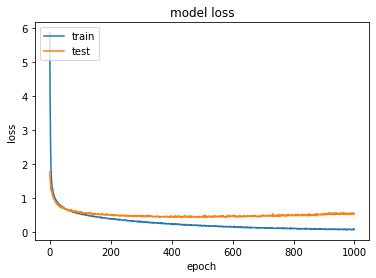

In [60]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

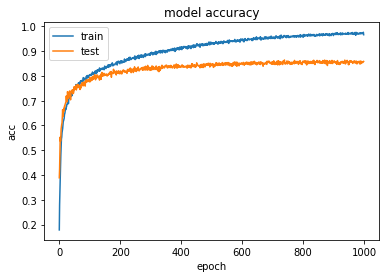

In [61]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
predictions = model.predict_classes(x_testcnn)

/home/systemcommand/bangkit/puput/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [63]:
predictions

array([3, 3, 3, ..., 1, 6, 2])

In [64]:
y_test

array([3, 3, 3, ..., 1, 6, 2], dtype=int32)

In [65]:
new_Ytest = y_test.astype(int)

In [66]:
new_Ytest

array([3, 3, 3, ..., 1, 6, 2])

In [67]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       192
           1       0.67      0.91      0.77       123
           2       0.91      0.79      0.85       264
           3       0.86      0.84      0.85       275
           4       0.90      0.87      0.88       252
           5       0.82      0.90      0.86       241
           6       0.88      0.84      0.86       197
           7       0.89      0.85      0.87       190

    accuracy                           0.86      1734
   macro avg       0.86      0.86      0.86      1734
weighted avg       0.87      0.86      0.86      1734



In [68]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[173  11   0   6   0   1   1   0]
 [  1 112   4   3   0   2   1   0]
 [  2  23 209   2  10  10   3   5]
 [  9   9   3 231   2  15   2   4]
 [  2   4   5   4 219   8   9   1]
 [  1   0   2  15   1 218   1   3]
 [  2   6   2   3   6   6 165   7]
 [  0   2   5   5   5   5   6 162]]


In [69]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/home/systemcommand/bangkit/puput/app/model/save/'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/systemcommand/bangkit/puput/app/model/save/Emotion_Voice_Detection_Model.h5 


In [70]:
loaded_model = keras.models.load_model('/home/systemcommand/bangkit/puput/app/model/save/Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_9 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_10 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 128)           

In [71]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

55/55 [==============================] - 1s 3ms/step - loss: 0.5450 - accuracy: 0.8587
Restored model, accuracy: 85.87%
